# 0 IMPORTS

In [153]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import psycopg2 as pg
import scikitplot as skplt
import pandas.io.sql as psql
import matplotlib.pyplot as plt

from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler, StandardScaler
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier

import warnings

warnings.filterwarnings( 'ignore' )

## 0.1 Funções auxiliares 

In [60]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    sns.set_palette("Reds") 
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [61]:
jupyter_settings()

## 0.2 Carregamento dos dados

In [62]:
# Credentials
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

In [63]:
conn = pg.connect(user=username,
                 password=pwd,
                 host=host,
                 port=port,
                 database=database)

In [64]:
query = """
        SELECT
            u.id,
            u.gender,
            u.age,
            u.region_code,
            u.policy_sales_channel,
            i.previously_insured,
            i.annual_premium,
            i.vintage,
            i.response,
            v.driving_license,
            v.vehicle_age,
            v.vehicle_damage
        FROM pa004.users as u 
        LEFT JOIN pa004.insurance as i ON (u.id = i.id)
        LEFT JOIN pa004.vehicle as v ON (u.id = v.id)
        """

In [65]:
df_raw = pd.read_sql(query, conn)
conn.close()

In [66]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.0,152.0,0,23367.0,249,0,1,< 1 Year,Yes
1,13,Female,41,15.0,14.0,1,31409.0,221,0,1,1-2 Year,No
2,18,Female,25,35.0,152.0,1,46622.0,299,0,1,< 1 Year,No
3,31,Female,26,8.0,160.0,0,2630.0,136,0,1,< 1 Year,No
4,39,Male,45,8.0,124.0,0,42297.0,264,0,1,1-2 Year,Yes


# 1 DESCRIÇÃO DOS DADOS

In [67]:
df1 = df_raw.copy()

## 1.1 Dimensão dos dados

In [68]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 381109
Número de colunas: 12


## 1.2 Tipo dos dados

In [69]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.3 Checagem de valores nulos

In [70]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4 Análise descritiva

In [71]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [72]:
num_attributes.columns

Index(['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'driving_license'],
      dtype='object')

In [73]:
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

### 1.4.1 Atributos númericos

In [74]:
# Central Tendency - mean, mediana, 25%, 75% // dispersion - std, min, max, 
ctd1 = num_attributes.describe()

#dispersion - range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#join
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']


medidas

,attributes,count,mean,std,min,25%,median,75%,max,range,skew,kurtosis
0,id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,381108.0,-8.071174e-18,-1.200000
1,age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,6.725390e-01,-0.565655
2,region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,52.0,-1.152664e-01,-0.867857
3,policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,162.0,-9.000081e-01,-0.970810
4,previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,1.0,1.677471e-01,-1.971871
5,annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,1.766087e+00,34.004569
6,vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,3.029517e-03,-1.200688
7,response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,1.0,2.301906e+00,3.298788
8,driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,1.0,-2.159518e+01,464.354302


<Figure size 2160x4320 with 0 Axes>

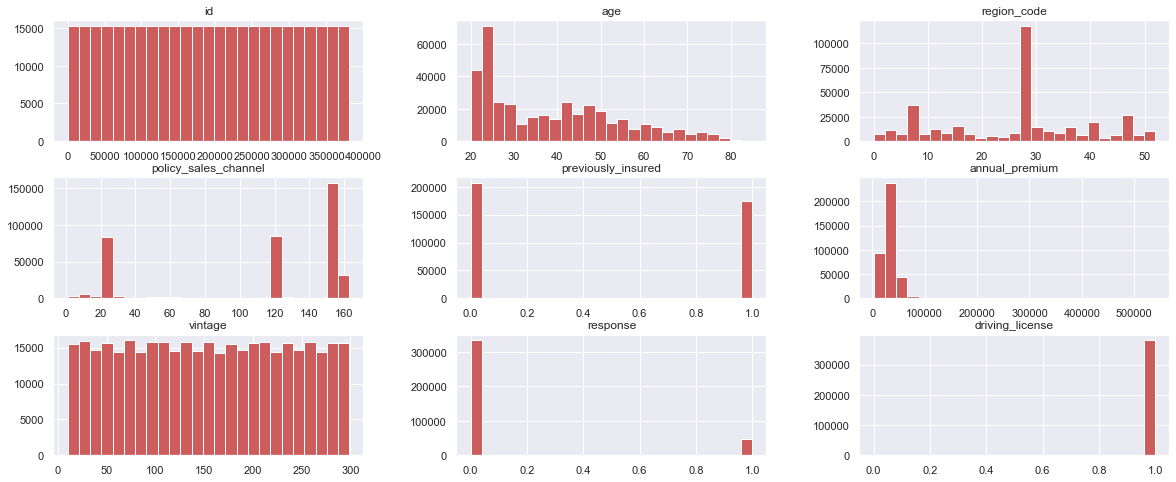

In [75]:
plt.figure(figsize = (30,60))
num_attributes.hist(bins= 25, color= 'indianred');

### 1.7.2 Atributos categóricos

In [76]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

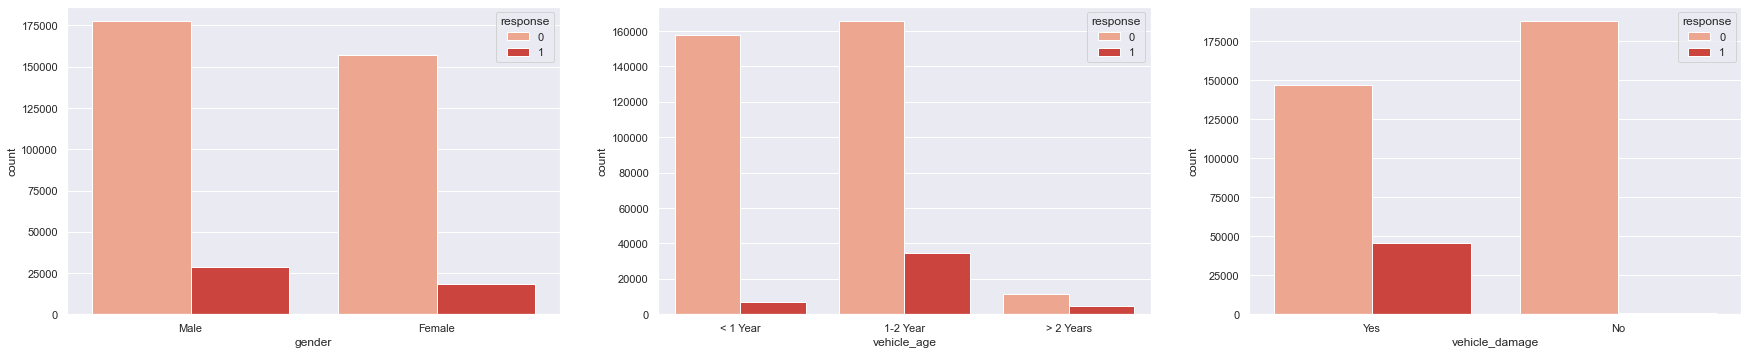

In [77]:
plt.figure(figsize = (30,60))

x = 1
for d in cat_attributes:
    plt.subplot(9, 3, x)
    sns.countplot( x=d, hue='response', data=df1, palette = 'Reds')
    x += 1


# 2 FEATURE ENGINEERING

In [78]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

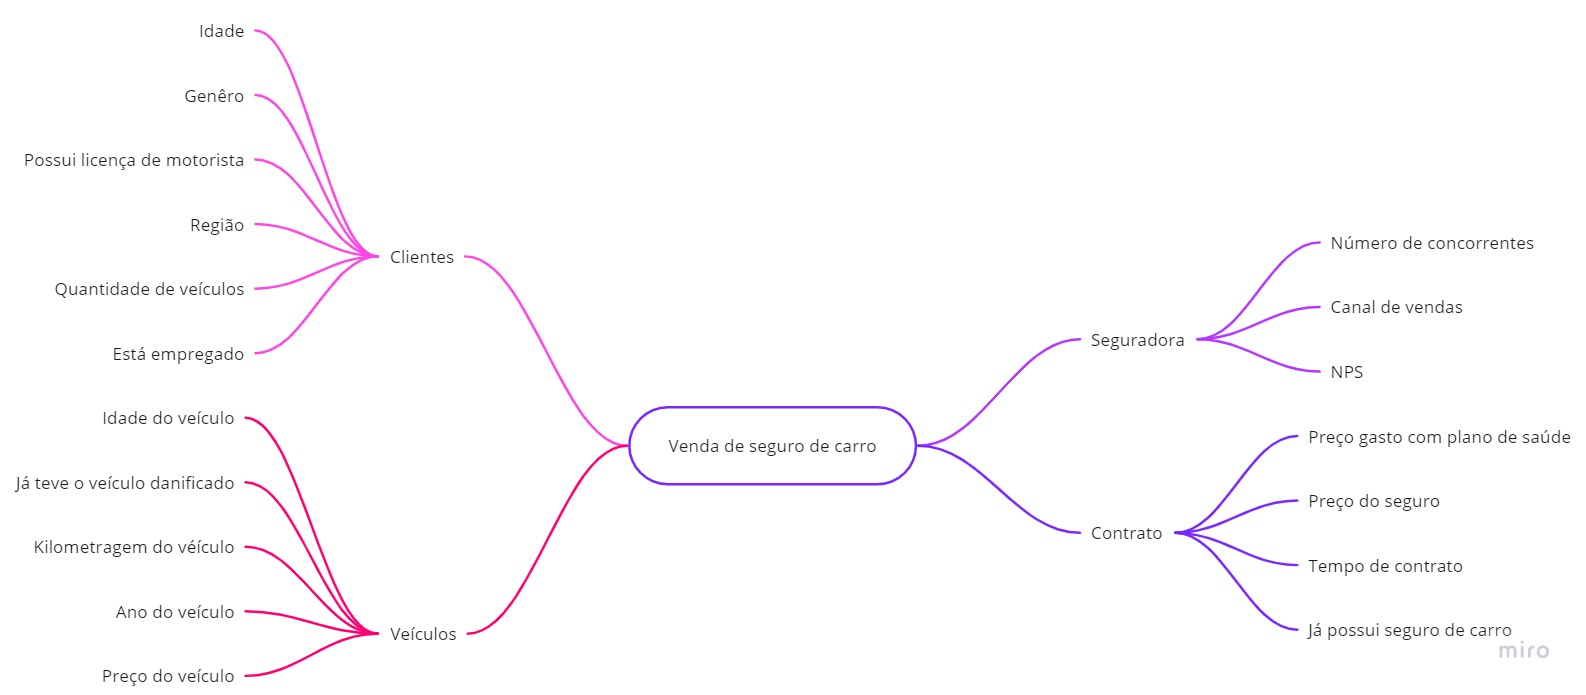

In [79]:
Image("../images/mapa_mental_seguros.jpg")

## 2.2 Criação das hipóteses

### Hipóteses dos Clientes
- Quanto maior a idade, maior a taxa de contratação do seguro
- Clientes do genêro masculino contratam mais o seguro
- Só contrata o seguro de carro quem possuí liceça de motorista
- Clientes que moram em regiões com fluxo de carro maior, contratam mais o seguro
- Regiões com mais Clientes na base contratam mais o seguro
- Clientes com mais veículos contratam mais o seguro
- Clientes empregados contratatam mais o seguro

### Hipóteses dos Veículos
- Quanto menor a faixa de idade do veículo, maior a taxa de contratação do seguro
- Se o veículo já foi danificado, maior é a taxa de contratação
- Quanto maior a kilometragem do veículo, menor é a taxa de contratação
- Quanto mais caro é o veículo, maior é a taxa de contratação do seguro

### Hipóteses da Seguradora
- Quanto maior o número de concorrentes, menor é a taxa de contratação
- Tem canais de vendas que a taxa de contratação é melhor
- Quanto maior o NPS da seguradora, maior é a taxa de contratação


### Hipóteses do Contrato
- Quanto maior a quantia gasto do cliente com o seguro de saúde, maior a taxa de contratação do seguro veicular
- Quanto maior o preço do seguro, menor a taxa de contratação
- Quanto maior o tempo de contrato/vínculo com a seguradora, maior a taxa de contratação
- Se o cliente já possuí seguro com outra seguradora, menor é a taxa de contratação

## 2.3 Criação de variáveis

In [80]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'below_1_year' if x == '< 1 Year' else 'between_1_2_years' if x == '1-2 Year' else 'over_2_years')

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3 FILTRAGEM DOS DADOS

In [81]:
df3 = df2.copy()

# 4 EDA

In [82]:
df4 = df3.copy()

In [83]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise univariada

### 4.1.1 Variável resposta

In [84]:
df4['response'].value_counts(normalize=True).reset_index().rename(columns={'index': 'response', 'response': 'pctg'})

,response,pctg
0,0,0.877437
1,1,0.122563


### 4.1.2 Variáveis númericas

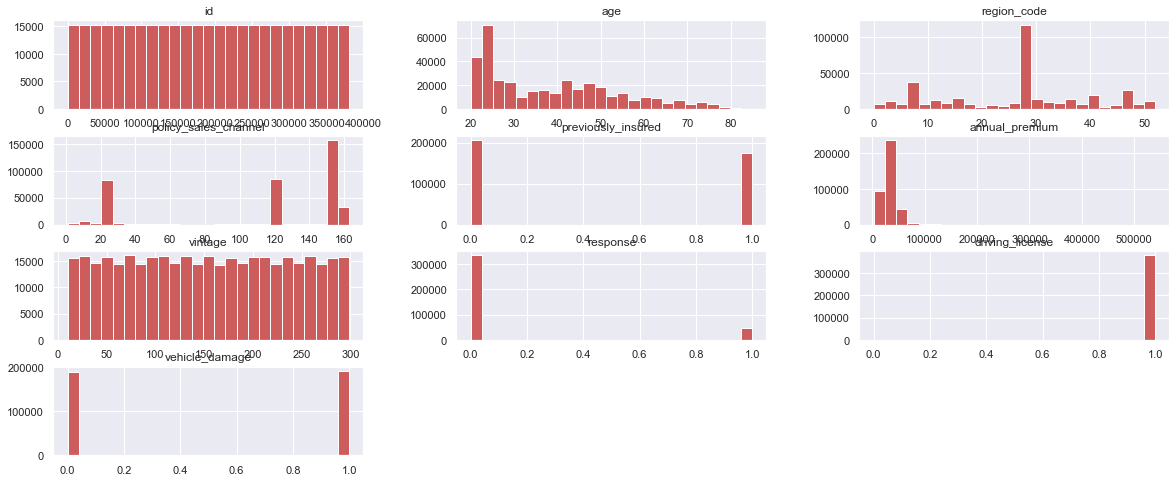

In [85]:
num_attributes.hist(color='indianred', bins=25);

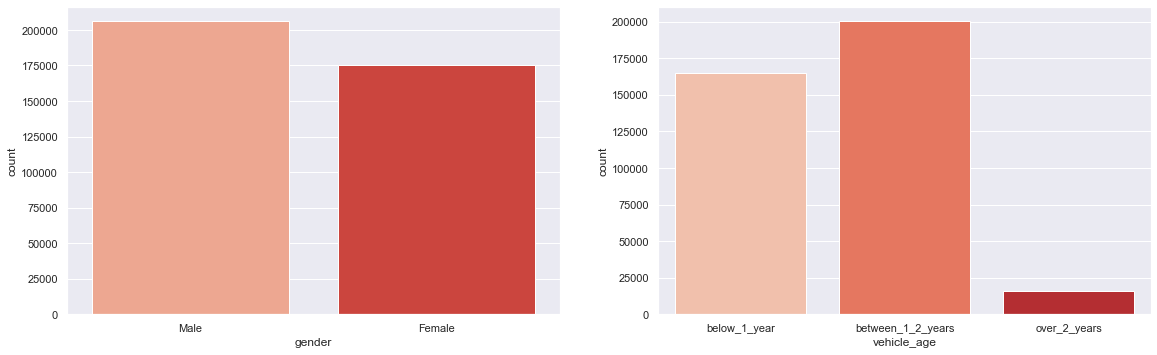

In [86]:
plt.figure(figsize = (30,60))

x = 1
for d in cat_attributes:
    plt.subplot(9, 3, x)
    sns.countplot( x=d, data=df4, palette = 'Reds')
    x += 1

## 4.2 Análise bivariada

### **H1: Quanto maior a idade, maior a taxa de contratação do seguro**
**FALSA** Entre as idades de 35-50 anos é onde tem a maior taxa de aceitação do seguro

<AxesSubplot:xlabel='response', ylabel='age'>

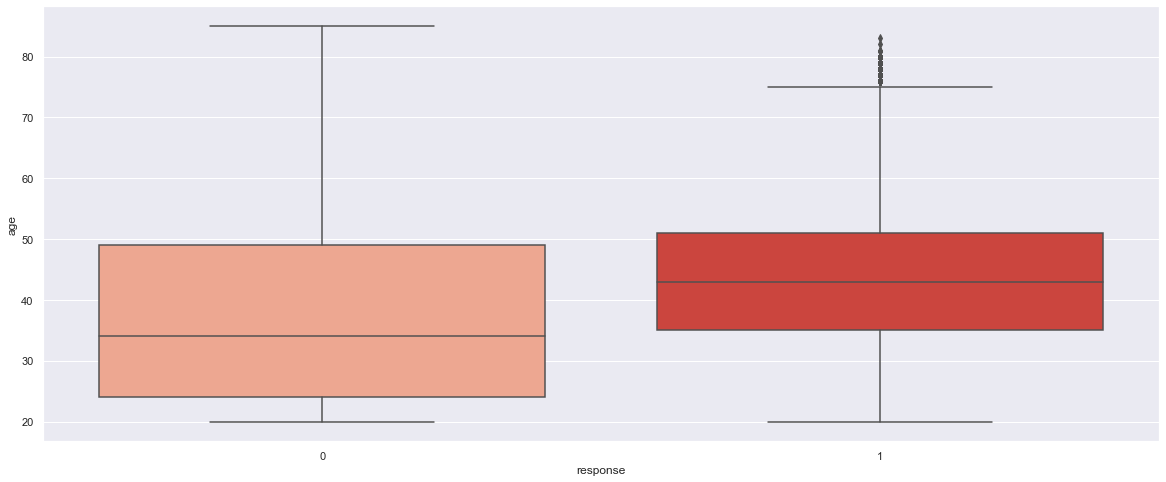

In [87]:
sns.boxplot( x=df4['response'], y=df4['age'], data=df4, palette = 'Reds')

<AxesSubplot:>

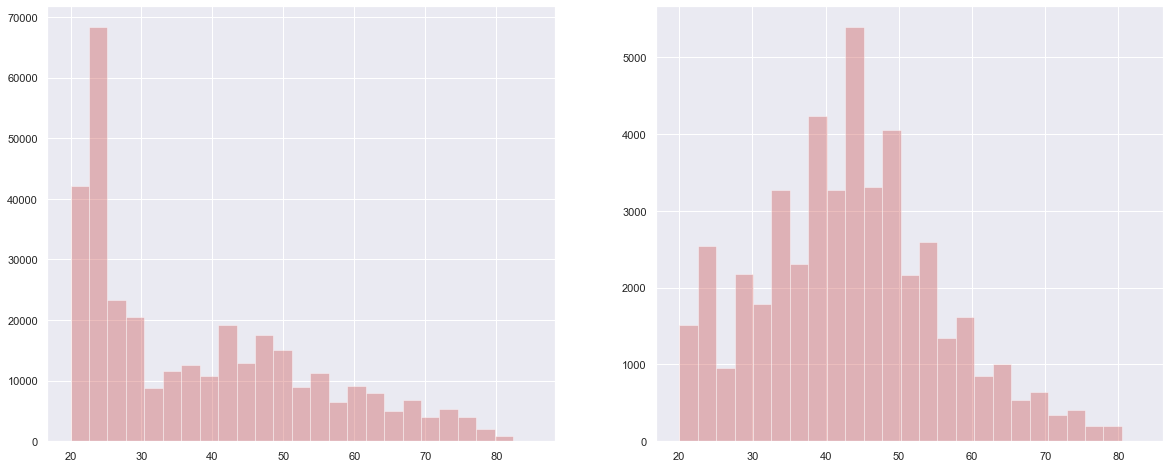

In [88]:
plt.subplot(1, 2, 1)
a1 = df4['age'][df4['response']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

plt.subplot(1, 2, 2)
a2 = df4['age'][df4['response']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

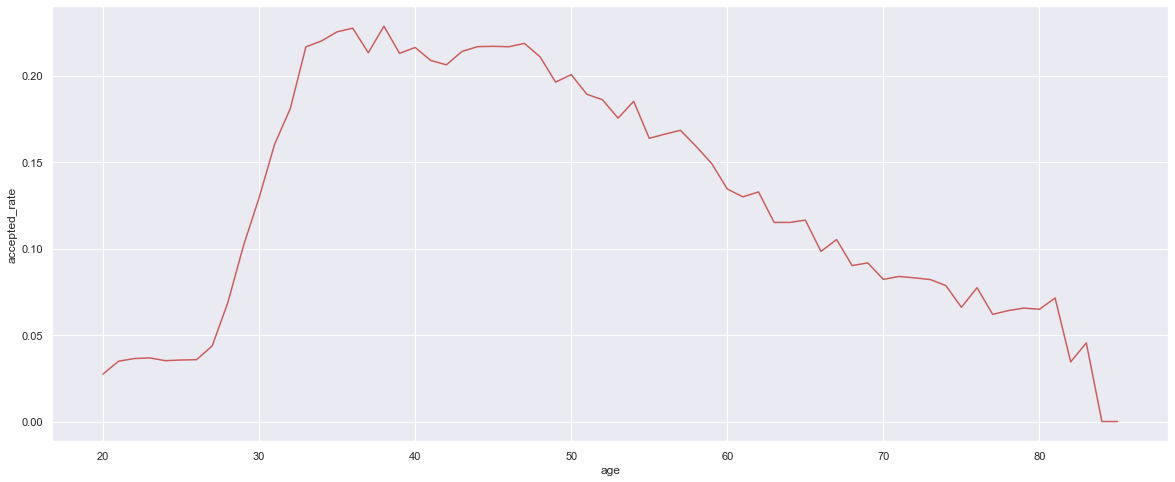

In [89]:
aux = df4.groupby('age')['response'].mean().reset_index().rename(columns={'index': 'age', 'response': 'accepted_rate'})
sns.lineplot(data=aux, x='age', y='accepted_rate', color='indianred');

### **H2: Só contrata o seguro de carro quem possuí licença de motorista**
**FALSA** Existe uma quantidade muito pequena da base que não possui licença de motorista, mas dentro dessa parcela, existe uma pequena quantia de pessoas que contratariam o serviço O.o

In [90]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

In [91]:
print(df4['driving_license'].value_counts())
df4['driving_license'].value_counts(normalize=True)

1    380297
0       812
Name: driving_license, dtype: int64


1    0.997869
0    0.002131
Name: driving_license, dtype: float64

In [92]:
pd.crosstab(df4['driving_license'], df4['response'], normalize='index')

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


### **H3:  Clientes do genêro masculino contratam mais o seguro
**FALSA** Clientes do genêro masculino possuem uma taxa de aceite maior, porém não é uma diferença significativa

<AxesSubplot:xlabel='gender', ylabel='count'>

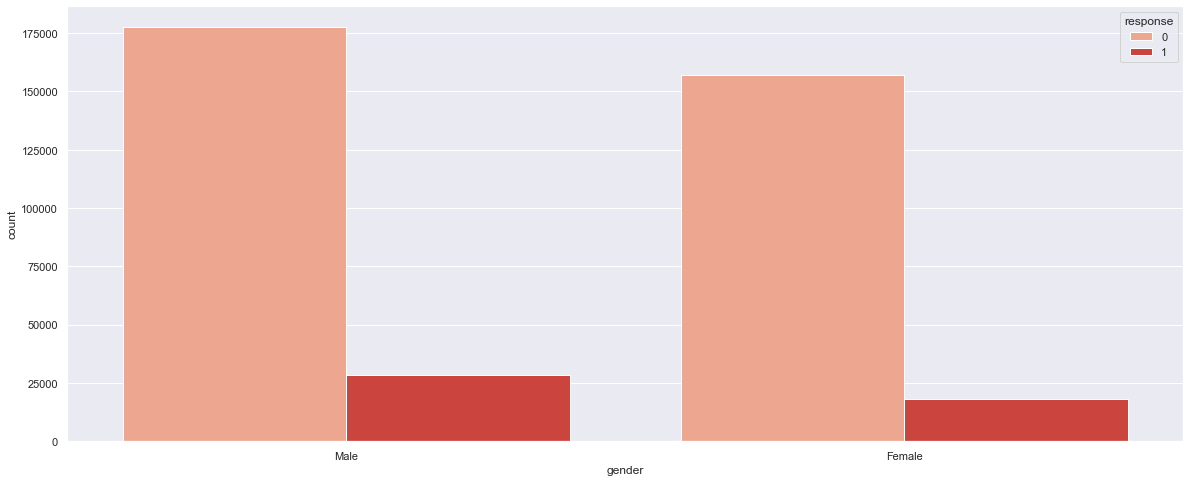

In [93]:
sns.countplot( x=df4['gender'], hue='response', data=df4, palette = 'Reds')

In [94]:
pd.crosstab(df4['gender'], df4['response'], normalize='index')

response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


### **H4: Algumas regiões contratam contratam mais o seguro**
**FALSA** Inconclusivo. Se a region code fosse lat lot poderia tirar alguma conclusão mais assertiva

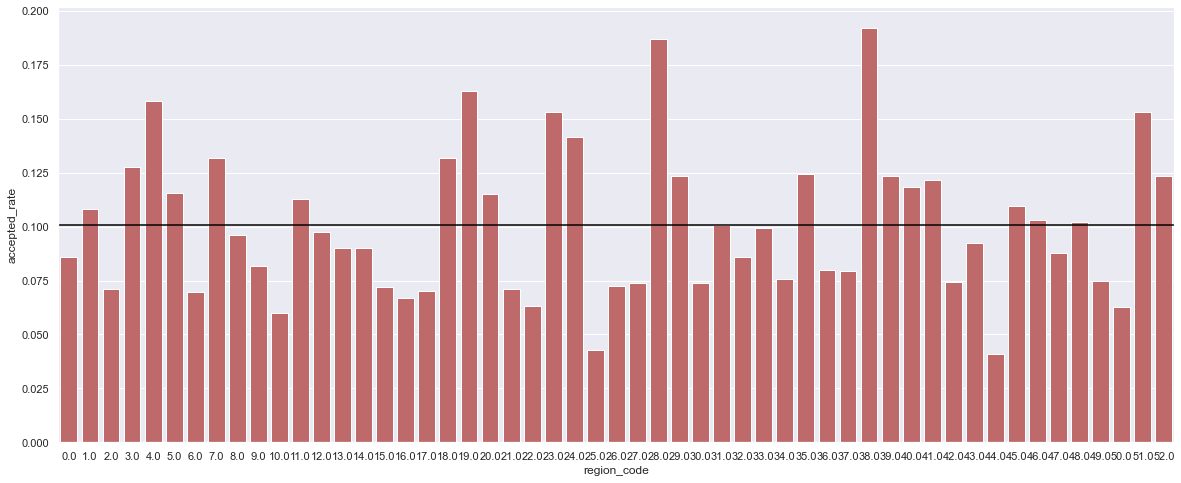

In [95]:
aux = df4.groupby('region_code')['response'].mean().reset_index().rename(columns={'index': 'region_code', 'response': 'accepted_rate'})
ax = sns.barplot(data=aux, x='region_code', y='accepted_rate', color='indianred')
ax.axhline(aux['accepted_rate'].mean(), color='black')

### **H5: Quanto menor a faixa de idade do veículo, maior a taxa de contratação do seguro**
**FALSA** Quanto maior a faixa de idade do veículo, amior a taxa de contratação

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

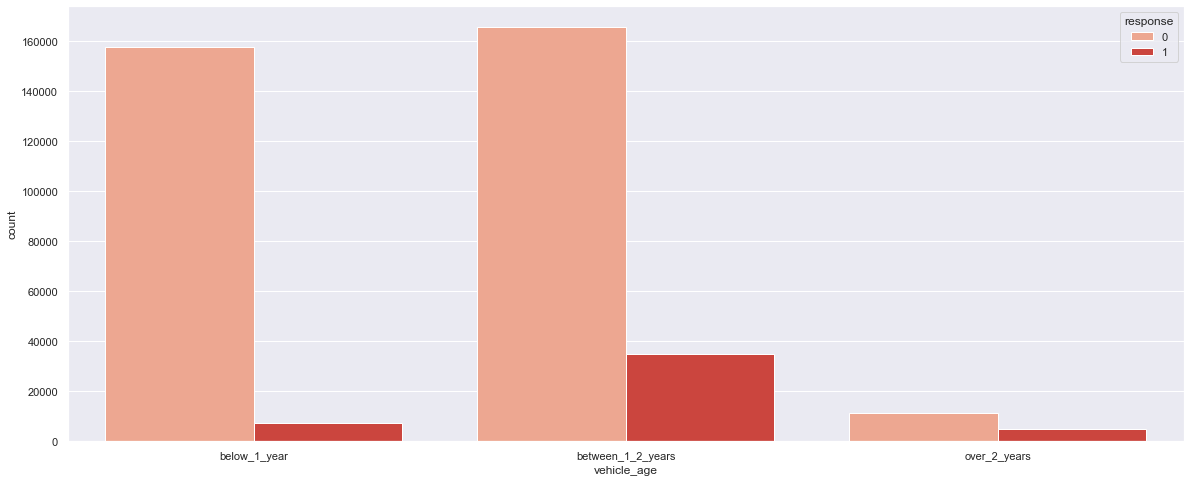

In [96]:
sns.countplot( x=df4['vehicle_age'], hue='response', data=df4, palette = 'Reds')

In [97]:
pd.crosstab(df4['vehicle_age'], df4['response'], normalize='index')

response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1_2_years,0.826245,0.173755
over_2_years,0.706254,0.293746


### **H6: Se o veículo já foi danificado, maior é a taxa de contratação**
**VERDADEIRA** Variável perigosa, praticamente todos que não tiveram o carro danificado no passado não contratariam

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

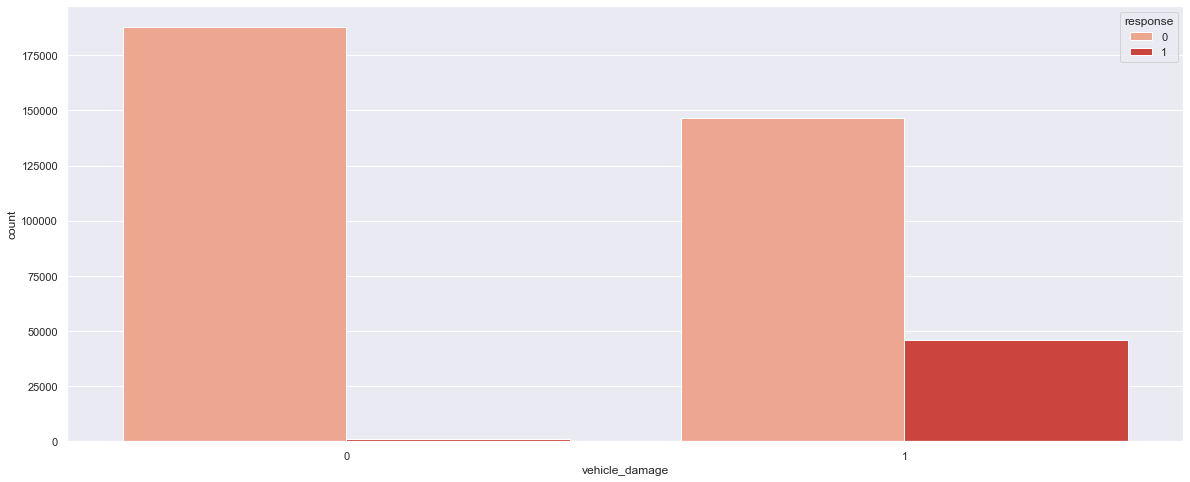

In [98]:
sns.countplot( x=df4['vehicle_damage'], hue='response', data=df4, palette = 'Reds')

In [99]:
pd.crosstab(df4['vehicle_damage'], df4['response'], normalize='index')

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### **H7: Tem canais de vendas que a taxa de contratação é melhor**
**VERDADEIRA** Existem canais onde a taxa de contratação do seguro é maior

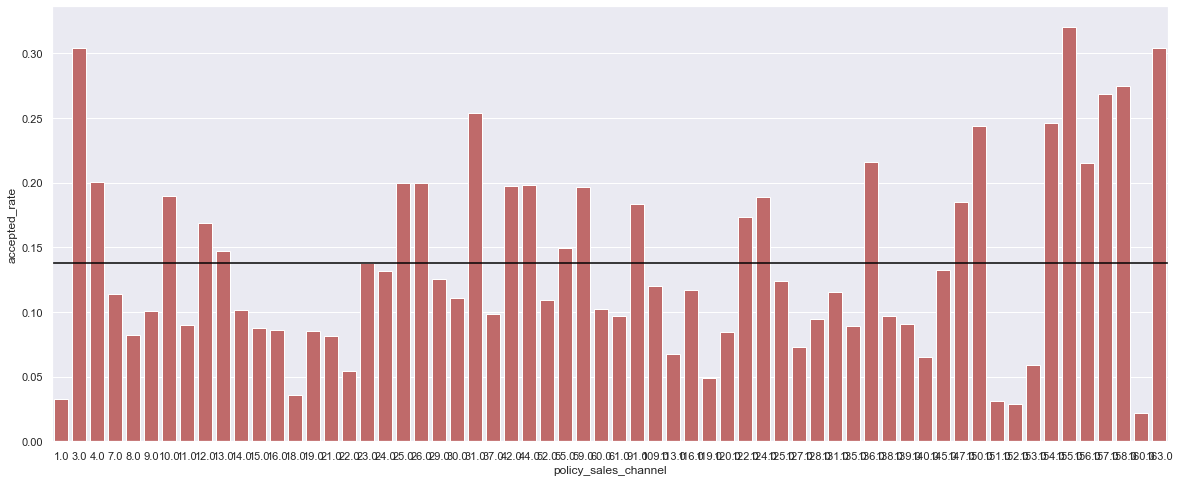

In [100]:
aux1 = df4[df4['policy_sales_channel'].map(df4['policy_sales_channel'].value_counts()) > 100]
aux2 = aux1.groupby('policy_sales_channel')['response'].mean().reset_index().rename(columns={'index': 'policy_sales_channel', 'response': 'accepted_rate'})
ax = sns.barplot(data=aux2, x='policy_sales_channel', y='accepted_rate', color='indianred')
ax.axhline(aux2['accepted_rate'].mean(), color='black');

### **H8: Quanto maior a quantia gasto do cliente com o seguro de saúde, maior a taxa de contratação do seguro veicular**
**FALSA** Visualmente, não parece haver relação entre o valor gasto com o seguro de saúde e a taxa de contratação do seguro veicular

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

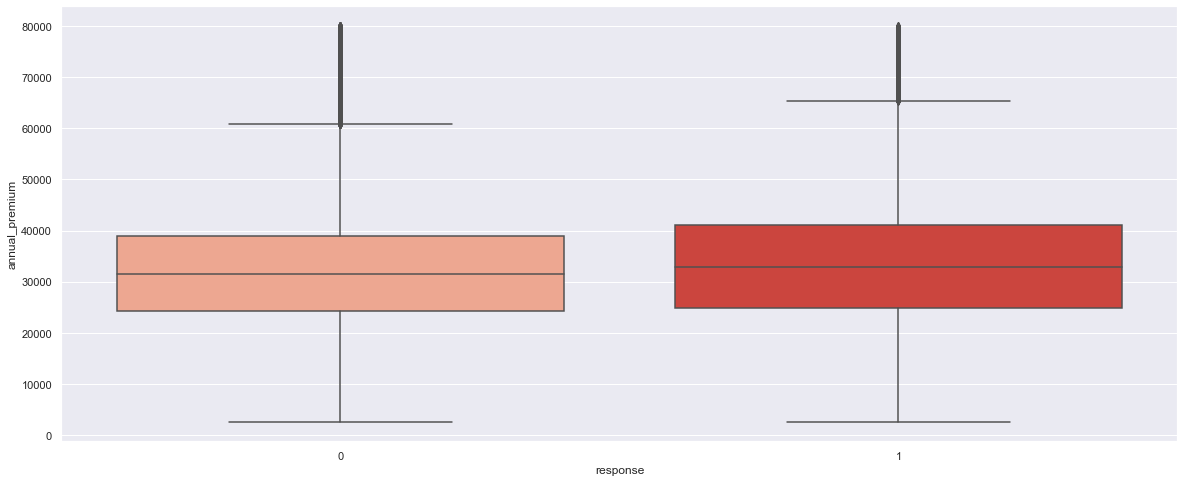

In [101]:
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x=aux['response'], y=aux['annual_premium'], data=aux, palette = 'Reds')

<AxesSubplot:>

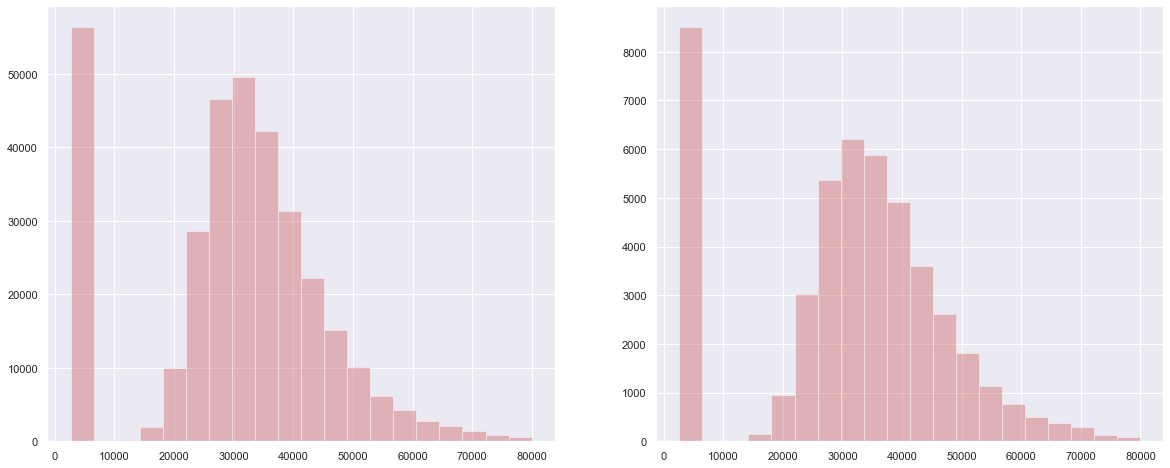

In [102]:
plt.subplot(1, 2, 1)
a1 = aux['annual_premium'][aux['response']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=20)

plt.subplot(1, 2, 2)
a2 = aux['annual_premium'][aux['response']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=20)

<AxesSubplot:xlabel='annual_premium', ylabel='count'>

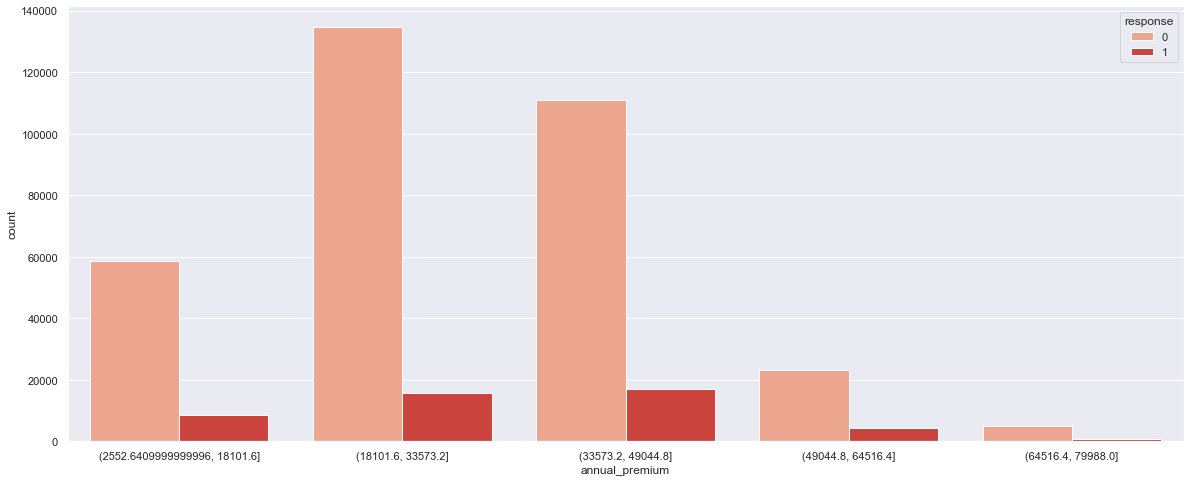

In [103]:
sns.countplot( x=pd.cut(x=aux['annual_premium'],
                       bins=5,
                       include_lowest=True), hue='response', data=aux, palette = 'Reds')

### **H9: Quanto maior o tempo de contrato/vínculo com a seguradora, maior a taxa de contratação**
**FALSA** A variável tem uma distribuição uniforme, sem impacto nenhum em relação a variável resposta

<AxesSubplot:xlabel='response', ylabel='vintage'>

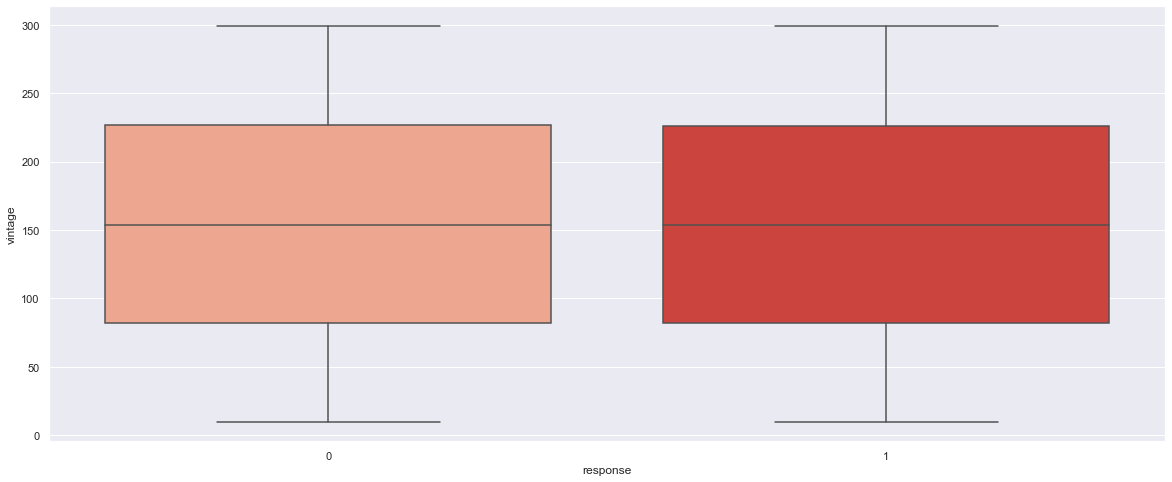

In [104]:
sns.boxplot( x=df4['response'], y=df4['vintage'], data=df4, palette = 'Reds')

<AxesSubplot:>

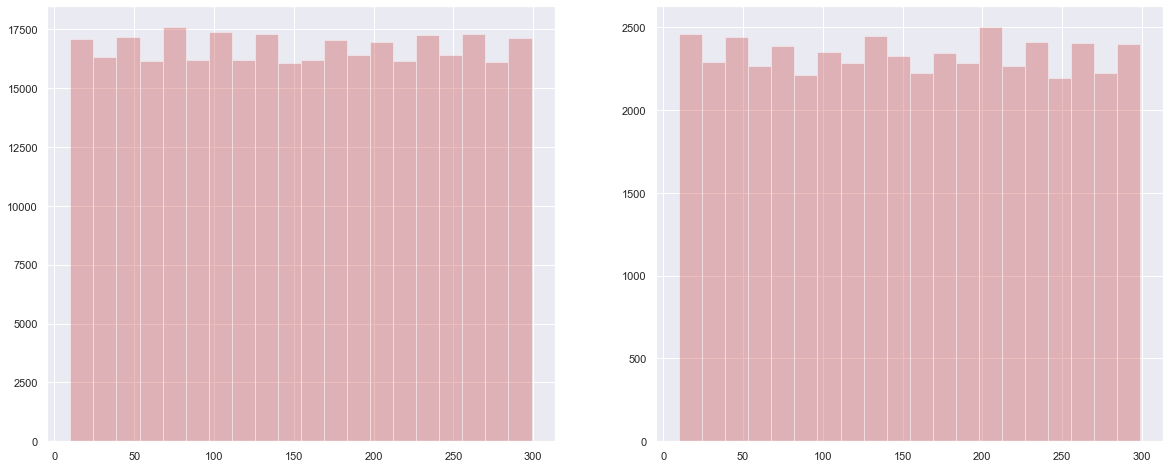

In [105]:
plt.subplot(1, 2, 1)
a1 = df4['vintage'][df4['response']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=20)

plt.subplot(1, 2, 2)
a2 = df4['vintage'][df4['response']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=20)

### **H10: Se o cliente já possuí seguro com outra seguradora, menor é a taxa de contratação**
**VERDADEIRA** Variável perigosa, praticamente todos que já tem um contrato anterior, não aceitam o produto

<AxesSubplot:xlabel='previously_insured', ylabel='count'>

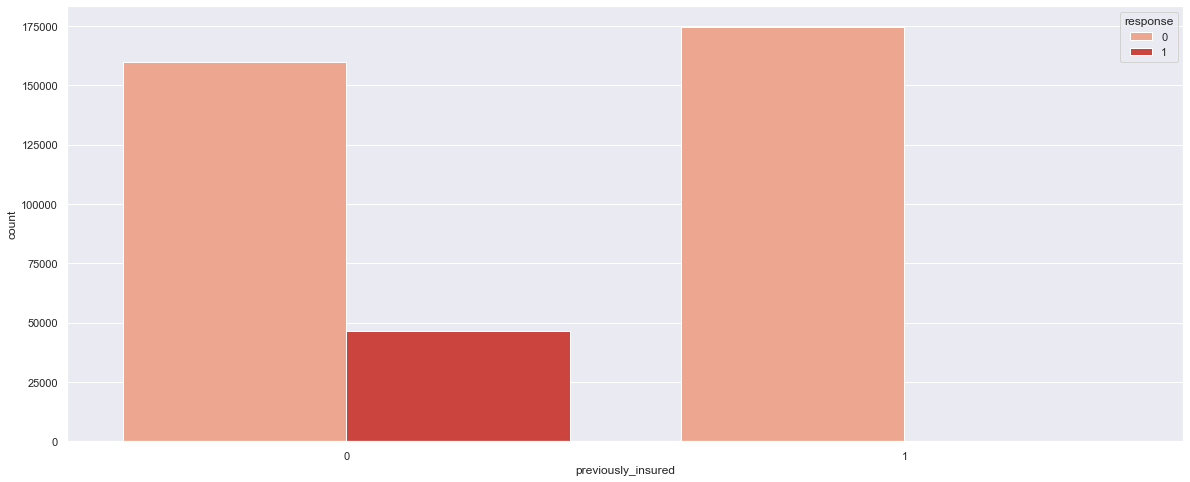

In [106]:
sns.countplot( x=df4['previously_insured'], hue='response', data=df4, palette = 'Reds')

In [107]:
pd.crosstab(df4['previously_insured'], df4['response'], normalize='index')

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


# 5 DATAPREP

In [136]:
df5 = df4.copy()

In [137]:
X = df5.drop('response', axis=1)
y = df5['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

## 5.1 Standardization

In [138]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2 Rescaling

In [139]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3 Encoder

In [140]:
# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# gender - One Hot Encoder
df5 = pd.get_dummies(df5, prefix='gender', columns=['gender'])

# vehicle_age - One Hot Encoder
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding
target_encode_policy_sales_channel = df5.groupby('policy_sales_channel')['response'].mean()
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(target_encode_policy_sales_channel)

## 5.4 Validation preparation

In [141]:
# annual_premium - StandardScaler
X_val.loc[:, 'annual_premium'] = ss.transform(X_val[['annual_premium']].values)

# age - MinMaxScaler
X_val.loc[:, 'age'] = mms_age.transform(X_val[['age']].values)

# vintage- MinMaxScaler
X_val.loc[:, 'vintage'] = mms_vintage.transform(X_val[['vintage']].values)

# region_code - Target Encoding
X_val.loc[:, 'region_code'] = X_val['region_code'].map(target_encode_region_code)

# gender - One Hot Encoder
X_val = pd.get_dummies(X_val, prefix='gender', columns=['gender'])

# vehicle_age - One Hot Encoder
X_val = pd.get_dummies(X_val, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding
X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map(target_encode_policy_sales_channel)

#fillna
X_val = X_val.fillna(0)

# 6 FEATURE SELECTION

In [142]:
df6 = df5.copy()

## 6.1 Feature importance

In [143]:
# definição do modelo
trees = ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# dataprep
X_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
trees.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature ranking:
                         feature  importance
0                        vintage    0.262780
0                 annual_premium    0.237658
0                            age    0.158380
0                    region_code    0.100224
0           policy_sales_channel    0.093456
0                 vehicle_damage    0.070697
0             previously_insured    0.050731
0       vehicle_age_below_1_year    0.013558
0  vehicle_age_between_1_2_years    0.007420
0       vehicle_age_over_2_years    0.003010
0                    gender_Male    0.000832
0                  gender_Female    0.000782
0                driving_license    0.000473


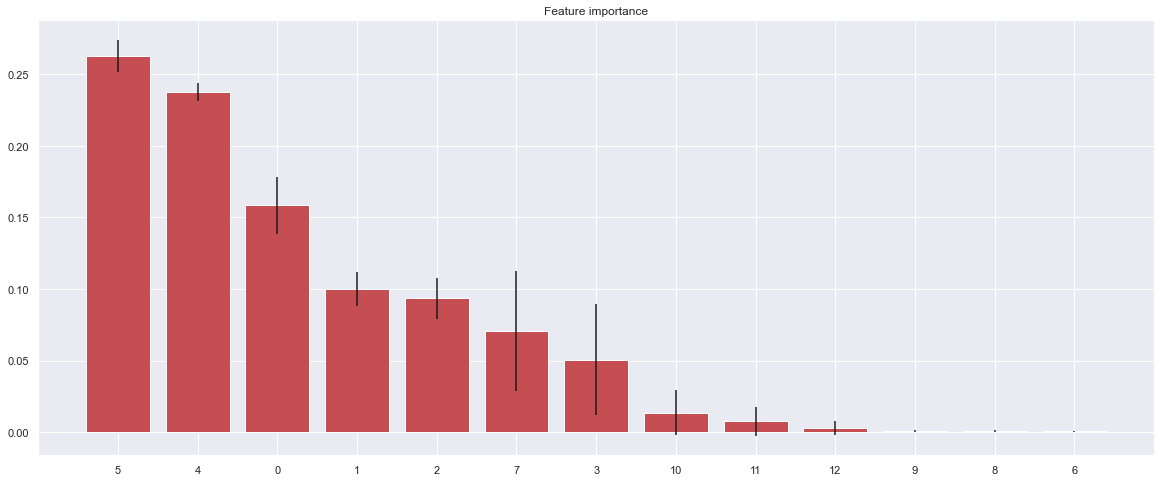

In [144]:
importances = trees.feature_importances_
std = np.std([tree.feature_importances_ for tree in trees.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# ranking de features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(X_train_n, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot feature importance impurity
plt.figure()
plt.title('Feature importance')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

## 6.2 Variáveis selecionadas manualmente 

In [145]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'policy_sales_channel', 'vehicle_damage', 'previously_insured']

# 7 MACHINE LEARNING

In [146]:
df7 = df6.copy()

In [147]:
X_train = df7[cols_selected]
X_validation = X_val[cols_selected]

## 7.1 KNN

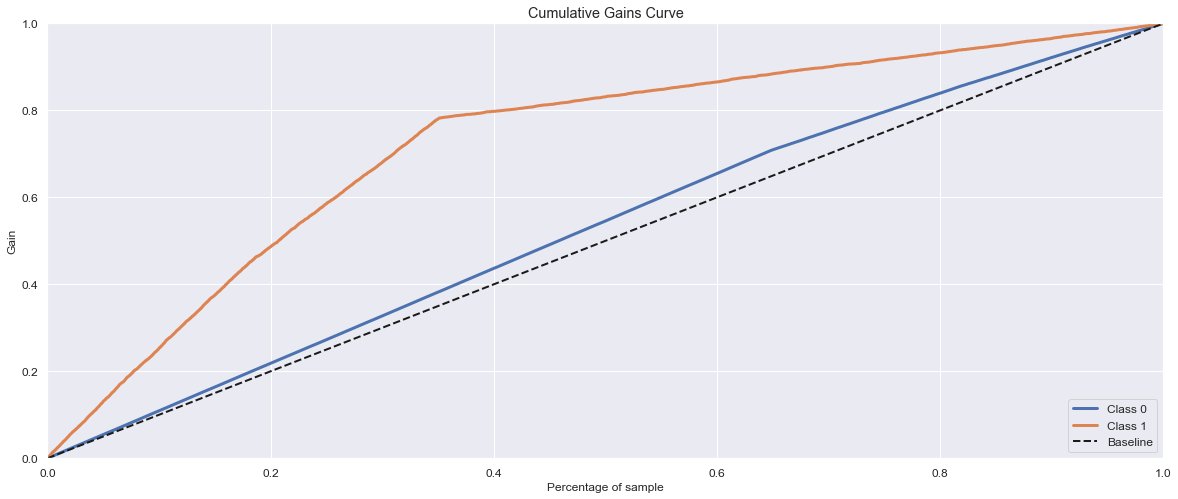

In [148]:
# inicializando estimador
knn = KNeighborsClassifier(n_neighbors=5)

# treino do modelo
knn.fit(X_train, y_train)

# predição do modelo
yhat_knn = knn.predict_proba(X_validation)

# Ganho acumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

## 7.2 Logistic Regression

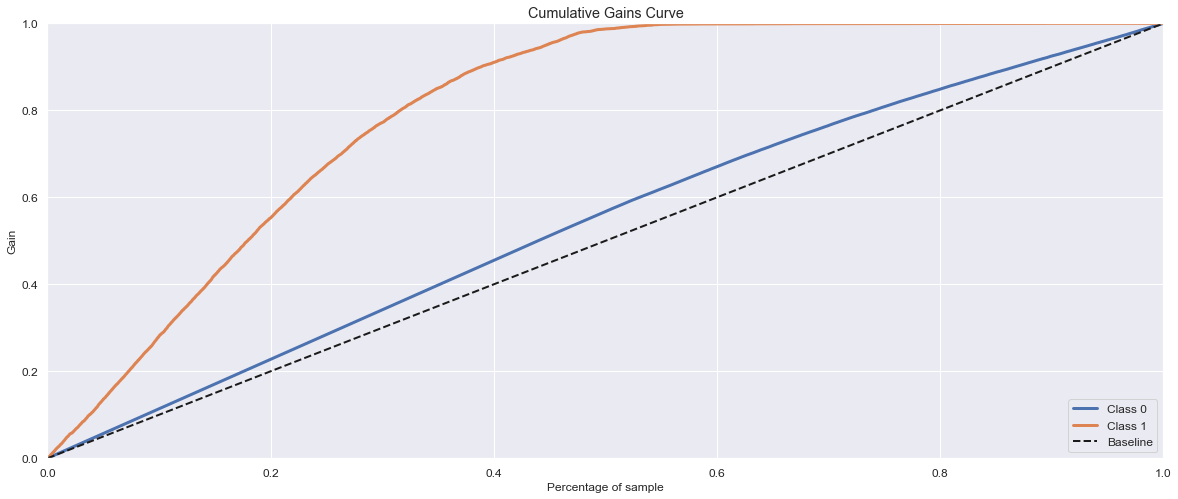

In [149]:
# inicializando estimador
lr = LogisticRegression()

# treino do modelo
lr.fit(X_train, y_train)

# predição do modelo
yhat_lr = lr.predict_proba(X_validation)

# Ganho acumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

## 7.3 Random Forest

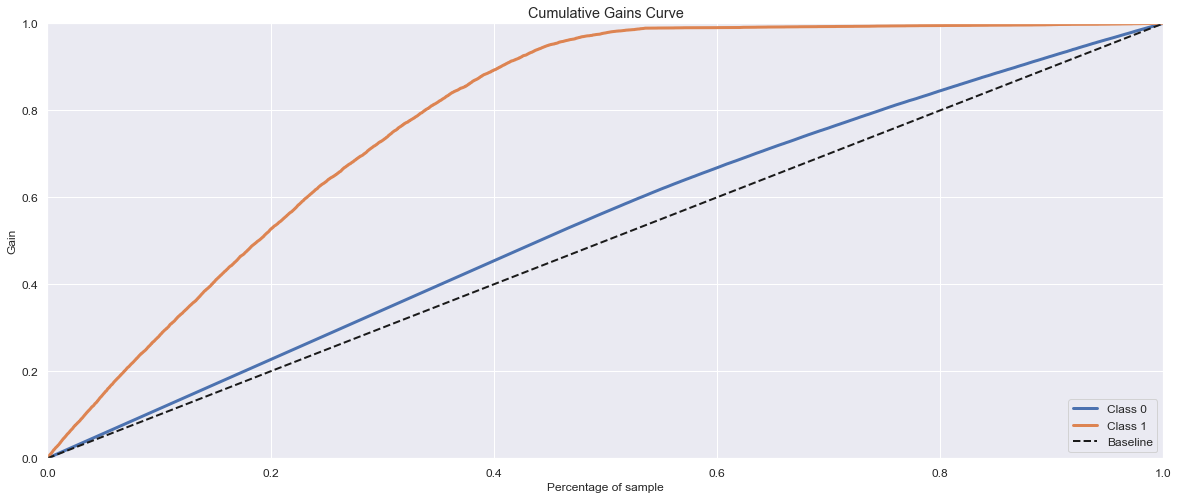

In [150]:
# inicializando estimador
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# treino do modelo
rf.fit(X_train, y_train)

# predição do modelo
yhat_rf = rf.predict_proba(X_validation)

# Ganho acumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

## 7.4 XGBoost

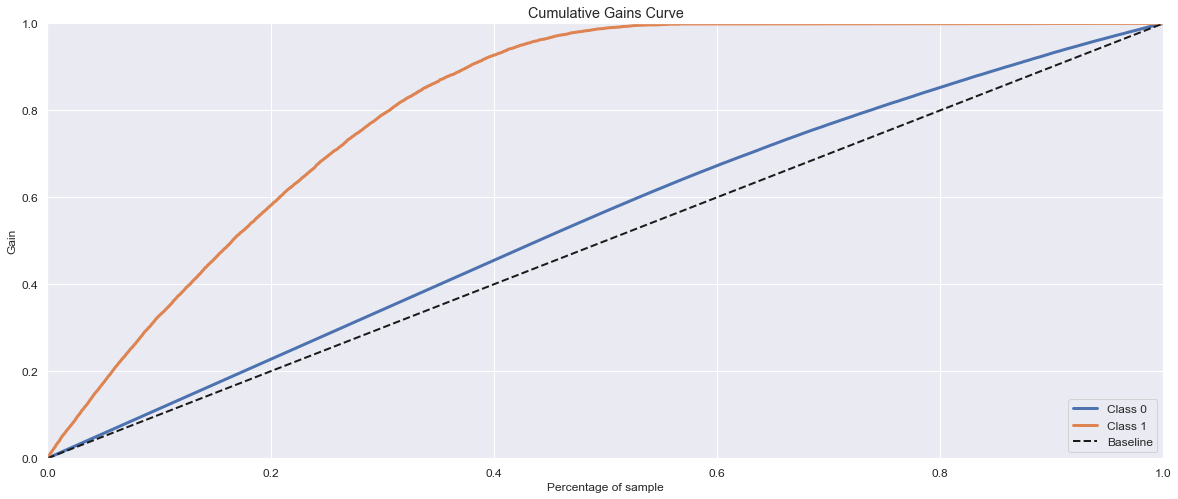

In [154]:
# inicializando estimador
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                        n_estimators=100,
                        eta=0.01,
                        max_depth=10,
                        subsample=0.7,                       
                        colsample_bytree=0.9)

# treino do modelo
xgb_model.fit(X_train, y_train)

# predição do modelo
yhat_xgb = xgb_model.predict_proba(X_validation)

# Ganho acumulativo
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);